# 1. Overview of Chatbot Personality Analysis

This notebook provides an overview of this research product by describing the research questions, the data gathered, and the analysis conducted. Each research question is addressed in a separate notebook as follow:
  
<code>
1_RQ1_user_experience.ipynb 
2_RQ2_personality_simulation.ipynb 
3_RQ3_user_personality.ipynb 
</code>


# 2. Research Questions

#### RQ1: Does the personality demonstrated by a chatbot affect the user’s experience?

- Which chatbot did the participant prefer? (show counts for each chatbot - bar chart, pie chart, ratio etc.)
    - How does this align with the participant's personality? (correlation between extraversion and preference, agreebleness and preference, can use logistic regression or point biserial correlation)
- Is the preferred chatbot experience positively correlated with conversation engagement metrics such as conversation length? (logistic regression)


#### RQ2: Can Personality be simulated by a chatbot?

- Do participants reliably identify differences between chatbot personality?
- Do participants prefer one chatbot over the other because of its personality?

#### RQ3: Can a user’s personality be inferred through their interaction with a chatbot?

- Do self-described personality traits (beliefs) correlate with interaction metrics (behaviour)?
- Can we use NLP on participant utterances to extract personality traits?
    - How do extracted personality traits correlate with self-described personality traits?


# 3. Data Gathered

Data for this analysis was gathered via an online user study in which participants interacted with two chatbots designed with disctinct personalities. The personalities differ across two factors of the Big 5 Personality Trait model (https://en.wikipedia.org/wiki/Big_Five_personality_traits). These factors are Extroversion (outgoing/energetic vs. solitary/reserved) and Agreeableness (friendly/compassionate vs. challenging/detached). Participants filled out a demographic and prsonality survey before interacting with the chatbots. After each interaction the participants filled out a survey about how they perceived the chatbot they just used. At the end of the experiment participants filled out a final survey describing which chatbot they preferred. 

# 4. Analysis

We analysis survey responses (text) as well as conversation logs (json). We extract features from the json data including number of conversation turns, average length of user utterances etc. 

***

### Read in dialog files (JSON)

Each user utterance in a conversation is stored in a separate JSON file which contains fields about the message, the user, and the conversation:

Message:
- type
- ID
- timestamp
- Text

User:
- ID
- Name

Conversation:
- ID

Bot:
- ID
- Name

We read in all files from 

In [1]:
import json
from pandas.io.json import json_normalize
import os
import logging
import logging.handlers
import pandas as pd
import numpy as np
import glob
from datetime import datetime,timedelta
from collections import Counter

In [2]:
def dt_parse(t):
    ''' 
    Function that parses datetime so it can be used to find duration of conversation
    INPUT: a string t representing a message timestamp
    OUTPUT: a string ret representing the message timestamp in the format %Y-%m-%dT%H:%M
    '''
    ret = datetime.strptime(t[0:16],'%Y-%m-%dT%H:%M')
    
    # Q: what do these lines do?
    if t[18]=='+':
        ret-=timedelta(hours=int(t[19:22]),minutes=int(t[23:]))
    elif t[18]=='-':
        ret+=timedelta(hours=int(t[19:22]),minutes=int(t[23:]))
    return ret 

# Interaction DataFrames

This code parses the json files from the chatbot interactions and stores the data in a dataframe with the following columns:

- Username (Participant name)
- Duration (Lenght of conversation in minutes)
- Chatbot (Name of chatbot)
- NumberOfTurns (absolute count of conversation turns) Q: is this just the users turns or the bot too?
- Utterance (A list of all the participant's utterances)
- Word Count (Total word count of all the participant's utterances (sum))
- Average Utterance Length (The average character length of the participant's utteranes (mean))


In [1]:
def create_utterance_df(rootDir):
    '''
    Function that traverses subfolders of a root directory 
    where each subfolder corresponds to a conversation with one of the chatbots.
    Each subfolder contains JSON files, each corresponding to a single user message. 
    '''
    
    jsdata = []
    df = pd.DataFrame(pd.np.empty((0, 7)))
    df.columns = ['Username','Duration', 'Chatbot', 'NumberOfTurns', 'Utterance','Word_Count', "Avg_Utt_Len"]

    for subdir, dirs, files in os.walk(rootDir): # each conversation has its own folder of json files
        for dir_ in dirs: # for each conversation
            message_timestamps = []
            user_utterances = []
            char_counts = []
            numberOfTurns = 0
            word_count = 0
            for file in glob.glob(rootDir+dir_+'/'+'*.json'):
                with open(file) as f:
                    data = json.load(f)
                    numberOfTurns += 1
                    message_timestamps.append(dt_parse(data['timestamp']))
                    user_utterances.append(data['text'])
                    for word in (data['text']).split():
                        word_count += 1
                    char_counts.append(len(data['text']) - data['text'].count(' '))
            avg_char_count = np.mean(char_counts)       


            #add post interaction survey (Nasoto)

            #Duration
            maxTime = max(dt for dt in message_timestamps)
            minTime = min(dt for dt in message_timestamps)
            duration =  maxTime - minTime

            #get the information from nasoto inserted
            jsdata.append({'Username': data['from']['name'],
                           'Duration': duration,'Chatbot': data['recipient']['name'], 
                           'NumberOfTurns' : numberOfTurns, 'Utterance': user_utterances, 
                            'Word_Count': word_count, 'Avg_Utt_Len': avg_char_count})



    df =  pd.DataFrame.from_records(jsdata)
    df[:]['Duration'] / np.timedelta64(1, 'm')
    return df  

In [2]:
df_nasoto = create_utterance_df('webchat-nasoto-pilot/')
df_nasoto

NameError: name 'pd' is not defined

In [3]:
df_makoto = create_utterance_df('webchat-makoto-pilot/')
df_makoto

NameError: name 'pd' is not defined

# Demographic and Personality Dataframes

In [6]:
PreInteractionPath = 'surveys-pilot/Pre-InteractionSurvey-Pilot.csv'
df_dem = pd.read_csv(PreInteractionPath,  error_bad_lines=False)
df_dem.head()

,Timestamp,Username,Total score,Age,Age [Score],Age [Feedback],Gender,Gender [Score],Gender [Feedback],Do you know what a chatbot is?,...,I am considerate and kind to almost everyone [Feedback],"I am outgoing, sociable","I am outgoing, sociable [Score]","I am outgoing, sociable [Feedback]",I am sometimes rude to others,I am sometimes rude to others [Score],I am sometimes rude to others [Feedback],I like to cooperate with others,I like to cooperate with others [Score],I like to cooperate with others [Feedback]
0,2020/04/01 10:45:16 am CET,sorcha.nicconmara@ucdconnect.ie,0.00 / 0,18-24,-- / 0,NaN,Female,-- / 0,NaN,Yes,...,NaN,4,-- / 0,NaN,3,-- / 0,NaN,4,-- / 0,NaN
1,2020/04/01 1:45:07 pm CET,charles.kelly1@ucdconnect.ie,0.00 / 0,18-24,-- / 0,NaN,Male,-- / 0,NaN,Yes,...,NaN,4,-- / 0,NaN,4,-- / 0,NaN,4,-- / 0,NaN
2,2020/04/01 3:11:18 pm CET,chloe.foxe@ucdconnect.ie,0.00 / 0,18-24,-- / 0,NaN,Female,-- / 0,NaN,Yes,...,NaN,3,-- / 0,NaN,3,-- / 0,NaN,5,-- / 0,NaN
3,2020/04/01 6:44:12 pm CET,elizabeth.burke@ucdconnect.ie,0.00 / 0,18-24,-- / 0,NaN,Female,-- / 0,NaN,Yes,...,NaN,5,-- / 0,NaN,1,-- / 0,NaN,5,-- / 0,NaN


In [7]:
keywords = ['[Score]', '[Feedback]']
cols = [c for c in df_dem.columns if any(x in c for x in keywords)]
cols.append('Total score')

# if any(x in str for x in a):

df_dem.drop(cols, axis = 1, inplace=True)
df_dem.columns

Index(['Timestamp', 'Username', 'Age', 'Gender',
       'Do you know what a chatbot is?',
       'If Yes, describe your understanding of what a chatbot is ',
       'How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?',
       'I am reserved', 'I tend to find fault with others',
       'I am helpful and unselfish with others', 'I am full of energy',
       'I start quarrels with others', 'I generate a lot of enthusiasm ',
       'I have a forgiving nature', 'I tend to be quiet ',
       'I am generally trusting', 'I have an assertive personality',
       'I can be cold and aloof ', 'I am sometimes shy, inhibited',
       'I am considerate and kind to almost everyone',
       'I am outgoing, sociable ', 'I am sometimes rude to others',
       'I like to cooperate with others'],
      dtype='object')

In [8]:
df_dem #TO DO strip usernames to match other dataframes

,Timestamp,Username,Age,Gender,Do you know what a chatbot is?,"If Yes, describe your understanding of what a chatbot is","How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?",I am reserved,I tend to find fault with others,I am helpful and unselfish with others,...,I have a forgiving nature,I tend to be quiet,I am generally trusting,I have an assertive personality,I can be cold and aloof,"I am sometimes shy, inhibited",I am considerate and kind to almost everyone,"I am outgoing, sociable",I am sometimes rude to others,I like to cooperate with others
0,2020/04/01 10:45:16 am CET,sorcha.nicconmara@ucdconnect.ie,18-24,Female,Yes,A program/piece of software that imitates huma...,Never,2,3,4,...,4,2,4,4,1,4,4,4,3,4
1,2020/04/01 1:45:07 pm CET,charles.kelly1@ucdconnect.ie,18-24,Male,Yes,An ai that attempts to replicate human convers...,Somewhat,4,5,4,...,3,4,3,2,4,4,4,4,4,4
2,2020/04/01 3:11:18 pm CET,chloe.foxe@ucdconnect.ie,18-24,Female,Yes,A chatbot is a computer program with human cap...,Somewhat,4,2,4,...,2,4,5,4,5,3,4,3,3,5
3,2020/04/01 6:44:12 pm CET,elizabeth.burke@ucdconnect.ie,18-24,Female,Yes,Artificial Intelligence capable of holding a c...,Somewhat,2,3,5,...,2,2,4,4,1,1,5,5,1,5


# Personality Assignment

Automation of personality assignment

In [9]:
extraversion = ((6 - df_dem['I am reserved']) 
        + df_dem['I am full of energy'] 
        + df_dem['I generate a lot of enthusiasm '] 
        + (6 - df_dem['I tend to be quiet ']) 
        + df_dem['I have an assertive personality'] 
        + (6 - df_dem['I am sometimes shy, inhibited']) 
        + df_dem['I am outgoing, sociable '])


df_dem["extraversion_score"] = extraversion
               
               
agreeableness = ((6 - df_dem['I tend to find fault with others']) 
        + df_dem['I am helpful and unselfish with others']
        + (6 - df_dem['I start quarrels with others'] )
        + df_dem['I have a forgiving nature'] 
        + df_dem['I am generally trusting'] 
        + (6 - df_dem['I can be cold and aloof '])
        + df_dem['I am considerate and kind to almost everyone']
        + ( 6 - df_dem['I am sometimes rude to others']) 
        + df_dem['I like to cooperate with others'])
df_dem["agreeableness_score"] = agreeableness




In [10]:
df_dem

,Timestamp,Username,Age,Gender,Do you know what a chatbot is?,"If Yes, describe your understanding of what a chatbot is","How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?",I am reserved,I tend to find fault with others,I am helpful and unselfish with others,...,I am generally trusting,I have an assertive personality,I can be cold and aloof,"I am sometimes shy, inhibited",I am considerate and kind to almost everyone,"I am outgoing, sociable",I am sometimes rude to others,I like to cooperate with others,extraversion_score,agreeableness_score
0,2020/04/01 10:45:16 am CET,sorcha.nicconmara@ucdconnect.ie,18-24,Female,Yes,A program/piece of software that imitates huma...,Never,2,3,4,...,4,4,1,4,4,4,3,4,25,36
1,2020/04/01 1:45:07 pm CET,charles.kelly1@ucdconnect.ie,18-24,Male,Yes,An ai that attempts to replicate human convers...,Somewhat,4,5,4,...,3,2,4,4,4,4,4,4,16,27
2,2020/04/01 3:11:18 pm CET,chloe.foxe@ucdconnect.ie,18-24,Female,Yes,A chatbot is a computer program with human cap...,Somewhat,4,2,4,...,5,4,5,3,4,3,3,5,23,31
3,2020/04/01 6:44:12 pm CET,elizabeth.burke@ucdconnect.ie,18-24,Female,Yes,Artificial Intelligence capable of holding a c...,Somewhat,2,3,5,...,4,4,1,1,5,5,1,5,30,38


# Summary Stats

In [11]:
import plotly.express as px

In [12]:
#merge df_nasoto with df_makoto
df_cd = df_nasoto.append(df_makoto)
# convert duratin to minutes from ns
df_cd = df_cd.astype({'Duration': 'timedelta64[m]'})

## Box Plot  Interaction Duration

In [4]:
fig = px.box(df_cd , "Chatbot", "Duration", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Duration of Interaction in Minutes",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Duration (Minutes)",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

NameError: name 'px' is not defined

In [14]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

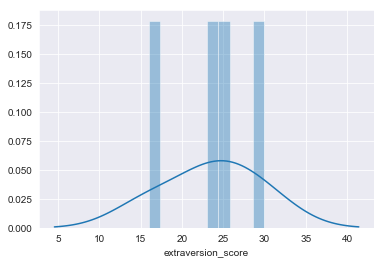

In [15]:
sns.distplot(df_dem['extraversion_score'], bins=10)

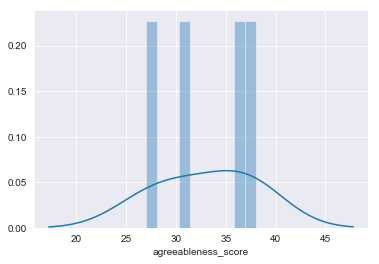

In [16]:
sns.distplot(df_dem['agreeableness_score'], bins=10)

## Extraversion vs. Agreeableness

In [17]:
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
%matplotlib inline

slope is 0.9190240452616701


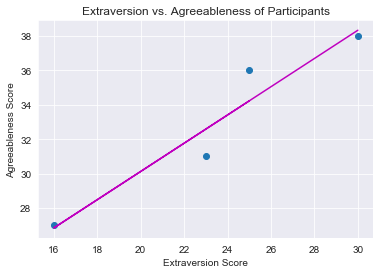

In [18]:
#df.plot.scatter(x='jacc_Score', y='reject_pc', title='Percentage Rejection by Jaccard Score')

x = [score for score in df_dem['extraversion_score']]
y = [score for score in df_dem['agreeableness_score']]

z = np.polyfit(x, y, 1)     # returns vector of coefficients that minimizes least squares error
plt.scatter(x, y)

p = np.poly1d(z)      # calculates y-axis data points

slope = (max(p) - min(p))/ (max(x) - min(x))
print(f'Slope is {slope}')

plt.title('Extraversion vs. Agreeableness of Participants')
plt.xlabel('Extraversion Score')
plt.ylabel('Agreeableness Score')

plb.plot(x, p(x), 'm-')

plt.show()